In [1]:
%load_ext autoreload
%autoreload 2

from model_utils import train_model, split_data
from config import Config
import json
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import os
import datasets
import torch
import transformers
from model_manager import ModelManager

In [2]:
seed = random.randint(0, 2 ** 32 - 1)
random.seed(seed)
datasets.logging.set_verbosity(datasets.logging.ERROR)
# Tell pytorch to run this model on the GPU.
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
# device_name = "cpu"
device = torch.device(device_name)
print(f"Will use {device_name} for training with seed: {seed}")

Will use cuda:0 for training with seed: 2269736484


In [3]:
split_data(os.path.join(Config.work_dir, "awsw_story_input.txt"))

In [4]:
config = {
    "model_name": "EleutherAI/gpt-neo-125M",
    "lr": 6e-4,
    "warmup_factor": 0,
    "scheduler": "polynomial_decay_schedule_with_warmup",
    "lr_end": 2e-6,
    "power": 0.6,
    #"freeze_layer_rate": 1e-4,
    "freeze_from_steps": -1,
    "seed": seed,
    "num_epoch": 100,
    "to_freeze_count": 150
}

optuna_result_attachement = {
    'lr': 0.001,
    'scheduler': 'cosine_schedule_with_warmup',
    'to_freeze_count': 150,
    'warmup_factor': 1
}
config.update(optuna_result_attachement)
config

{'model_name': 'EleutherAI/gpt-neo-125M',
 'lr': 0.001,
 'warmup_factor': 1,
 'scheduler': 'cosine_schedule_with_warmup',
 'lr_end': 2e-06,
 'power': 0.6,
 'freeze_from_steps': -1,
 'seed': 2269736484,
 'num_epoch': 100,
 'to_freeze_count': 150}

In [5]:
train_results = {}
train_model(config, train_results, device = device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Dataset demo snapshot:
p msg c "Sounds great." d msg Lo "I did a staggering amount of research on mythical humans. Here, let me show you some of the stuff I found."<|endoftext|>p msg c "Right again. Have you played this game before?" d msg An "It's a children's game. These questions aren't really a challenge." msg An "I'll just go ahead and draw the next card, so we can end this." msg An "An adventurer who values his life has to choose between three rooms to cross. Which one of the following would be the safest?" msg An "#1: A room filled with poisonous gas
. #2: A room filled with one hundred highly trained assassins. #3: A room submerged in water filled with alligators that have not eaten in eight months." p msg c "#2, the room filled with one hundred highly trained assassins." p msg c "Right again. Have you played this game before?" d msg An "It's a children's game. These questions aren't really a challenge." msg An "I'll just go ahead and draw the next card, so we can end this." ms

Step,Training Loss
38,3.268700
76,2.643600
114,2.474100
152,2.382800
190,2.243000
228,2.143600
266,2.063700
304,1.982100
342,1.909800
380,1.845900


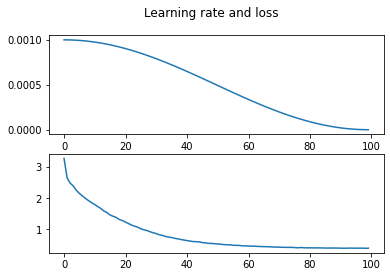

In [6]:
fig, axs = plt.subplots(2)
fig.suptitle('Learning rate and loss')
axs[0].plot(train_results['learning_rate_history'])
axs[1].plot(train_results['loss_history'])

# Testing

We created a few past (for context) + present prompts (player input) and see the different reactions. This way, we can test the models across different iterations.

In [7]:
train_results['model'].eval()
model_manager = ModelManager(model=train_results['model'], tokenizer=train_results['tokenizer'])

In [8]:
prompts = [
    ('msg p c "Hey Remy!" msg d Ry "Hey!"', "How are you?"),
    ('msg p c "I was with Lorem today." msg d Ad "Very nice."', "What do you think of Lorem?"),
    ('msg d m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('msg d m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
]

for (past, prompt) in prompts:
    reply = model_manager.say(past, prompt)
    print(f"Prompt: {prompt}\nReply: {reply}\n\n")

Prompt: How are you?
Reply: msg Ry "Hey, [player_name] is here." d msg Ry "Hey,ettlement!"<|endoftext|>


Prompt: What do you think of Lorem?
Reply: msg Ad "It's good to see you! I thought you might not show up any time soon." d msg Ad "I suppose you could say the same thing about me." msg c "I'm not sure if you are aLiterai." d msg Ad "I see. I suppose you are very well-known."<|endoftext|>


Prompt: Oh my god, Adine. What is this?
Reply: msg Br "Do you remember thepictured event? Itowntown is going to be really badlyymmaclyymmaclyymmacly?" p msg c "No, I forgot to tell you about that." d msg Br "Did you go there?"<|endoftext|>


Prompt: What will we do here?
Reply: msg An "We can find out from him what the problem was. He's in a bad mood and really got away with it, but it's too bad."<|endoftext|>




# Sampling test

Which combination is the best?

In [ ]:
for i in range(100):
    torch.manual_seed(80085)
    top_k = random.randint(0, 100)
    top_p = round(random.uniform(0, 1), 2)
    for (past, prompt) in prompts:
        reply = model_manager.say(past, prompt, top_k = top_k, top_p = top_p)
        print(f"[Test {i + 1} top_k: {top_k}, top_p: {top_p}] -> Prompt: {prompt}\nReply: {reply}\n")
    print("-------------")

[Test 1 top_k: 46, top_p: 0.93] -> Prompt: How are you?
Reply: msg Ry "Hey, [player_name] is here." p msg c "Hey,ettlement." d msg m "ettlement?" msg m "izards are haphalinize." d msg Ry "izards canachoize."<|endoftext|>

[Test 1 top_k: 46, top_p: 0.93] -> Prompt: What do you think of Lorem?
Reply: msg Ad "It was a nice evening." msg c "I didn't want to do anything else, but I wasn't sure if there was anything else special that would help me with the application." d msg Ad "Maybe you should rest for a little bit, at least." msg c "I should stop by at the next day and... [player_name] I'll contact you later, but we've already talked about yourag Lumpur, then." d msg Ad "Come

[Test 1 top_k: 46, top_p: 0.93] -> Prompt: Oh my god, Adine. What is this?
Reply: msg Ad "Do you think so?"<|endoftext|>

[Test 1 top_k: 46, top_p: 0.93] -> Prompt: What will we do here?
Reply: msg Br "To be frank, I'm not sure. Back home, this whole thing is just... you know, youumbiny."<|endoftext|>

------------

In [ ]:
print("What to say?")
print(generate_dragon_reply("", input()))